In [1]:
import pyfastchem as pyfc
import os
import petitRADTRANS.physical_constants as nc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from tqdm import tqdm

In [2]:
class FastChemistry():

    def __init__(self, pressures, rainout=True):

        self.pressures = pressures

        # pyfc_path = os.path.dirname(pyfc.__file__)
        pyfc_path = os.path.abspath('/net/lem/data1/regt/fastchem/')
        self.element_file   = f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat'
        # self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended.dat'
        # self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates.dat'
        self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended_lithium.dat'
        self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates_lithium.dat'

        self.fastchem = pyfc.FastChem(
            self.element_file, self.logK_gas_file, self.logK_cond_file, 1
            )

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        # Use rainout condensation approach
        self.input.equilibrium_condensation = True
        self.input.rainout_condensation     = rainout

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-6)
        self.fastchem.setParameter('accuracyElementConservation', 1e-6)
        
        self.fastchem.setParameter('nbIterationsChem', 100000)

        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        self.index_Li = np.array(self.fastchem.getElementIndex('Li'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        gas_number_density = np.array(self.output.number_densities)[::-1,index]
        return (gas_number_density / self.gas_number_density_tot)
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]
    
    def get_element_cond_degree(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        return np.array(self.output.element_cond_degree)[::-1,index]
    
    def get_element_number_density(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        total_element_density  = np.array(self.output.total_element_density)[::-1]
        total_element_density *= np.array(self.fastchem.getElementAbundance(index)) / np.sum(self.fastchem.getElementAbundances())
        return (total_element_density / self.gas_number_density_tot)

    def __call__(self, T, CO=None, FeH=0., el_abund={'Li':10**(3.28-12)}):

        temperature = T * np.ones_like(self.pressures)
        if (temperature < 150).any():
            print('Replaced T<150 with T=150 K')
            temperature[temperature<150] = 150

        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        for element_i in el_abund.keys():
            index = self.fastchem.getElementIndex(element_i)
            element_abundances[index] = el_abund[element_i]

        # Apply C/O ratio and Fe/H to elemental abundances
        if CO is not None:
            CO_correction = (1 + element_abundances[self.index_C]/element_abundances[self.index_O]) / (1+CO)
            element_abundances[self.index_C] = element_abundances[self.index_O] * CO
            element_abundances[self.index_C] *= CO_correction
            element_abundances[self.index_O] *= CO_correction

        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        self.gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))

In [3]:
# T_eff = np.arange(700, 2400+1e-6, 300)
T_eff = np.array([700, 1000, 1300, 1600, 1900, 2200])
# T_eff = np.array([700,1000])

# VMR_tot = {'F': [], 'Fe': []}
# VMR  = {'F1H1': [], 'Fe': [], 'Fe1H1': [], 'Mg': [], 'Al1F1': [], 'Na': [], 'K': []}
VMR_tot = {'F': [], 'C': [], 'O': [], 'S': [], 'N': []}
VMR  = {'F1H1': [], 'C1O1': [], 'C1H4': [], 'H2O1': [], 'C1O2': [], 'H1O1': [], 'H2S1': [], 'H3N1': [], 'Al1F1': [], 'H1S1': [], 'C1O2': [], 'N2': []}
cond = {'Li2S(s)': [], 'LiF(s)': [], 'Mg2SiO4(s,l)': [], 'MgSiO3(s,l)': [], 'SiO(s)': [], 'Fe(s,l)': [], 'Na2S(s,l)': []}
cond_degree = {'Li': [], 'C': [], 'O': [], 'S': [], 'N': [], 'F': []}
P = []
T = []

for FeH_i in [0.0]:
    for T_eff_i in tqdm(T_eff):

        # Read temperature profile
        #path = '/home/sam/Documents/PhD/fastchem_tests/SONORA_ElfOwl_PT/' + \
        path = '/net/lem/data2/regt/SONORA_Elf_Owl/PT_profiles/' + \
            'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
            #'spectra_logzz_9.0_teff_{:.1f}_grav_1000.0_mh_0.0_co_1.0.dat'.format(T_eff_i)
        pressure, temperature = np.loadtxt(path).T

        # Compute the chemical equilibrium abundances
        FC = FastChemistry(pressures=pressure)
        
        CO = FC.solar_abundances[FC.index_C]/FC.solar_abundances[FC.index_O]
        FC(T=temperature, CO=CO, FeH=FeH_i)

        P.append(pressure)
        T.append(FC.input.temperature[::-1])

        for hill_i in VMR.keys():
            VMR[hill_i].append(FC.get_VMR(hill_i))
        for hill_i in cond.keys():
            cond[hill_i].append(FC.get_condensate_number_density(hill_i))
        
        for element_i in cond_degree.keys():
            cond_degree[element_i].append(FC.get_element_cond_degree(element_i))

        for element_i in VMR_tot.keys():
            VMR_tot_i = FC.get_element_number_density(element_i)
            VMR_tot[element_i].append(VMR_tot_i)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:34<00:00,  5.77s/it]


In [4]:
PT_cond = {species_i: [] for species_i in cond.keys()}
for species_i, n_i in cond.items():
    
    for j in range(len(P)):
        n_ij = n_i[j]
        mask_condensed = (n_ij != 0.)
        if not mask_condensed.any():
            continue
        
        idx = np.argwhere(mask_condensed).max()
        if idx == len(n_ij)-1:
            continue
        PT_cond[species_i].append([P[j][idx], T[j][idx]])

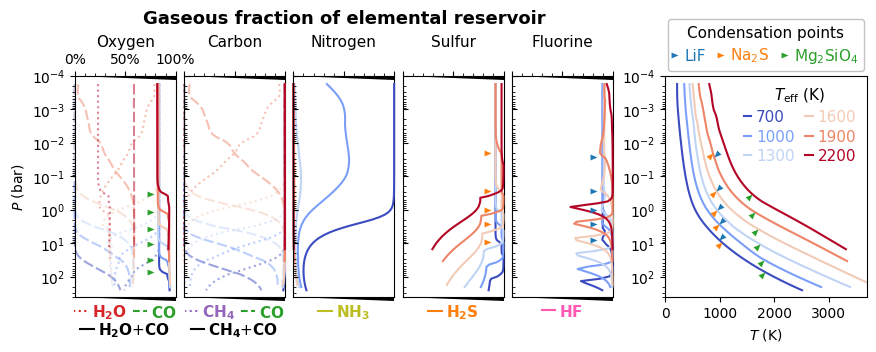

In [5]:
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=7, wspace=0.08, width_ratios=[0.2,0.2,0.2,0.2,0.2,0.07,0.4])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[0,2]), 
    fig.add_subplot(gs[0,3]), 
    fig.add_subplot(gs[0,4]), 
    fig.add_subplot(gs[0,-1]), 
])

for i, T_eff_i in enumerate(T_eff):

    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]-10
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    kwargs = dict(
        c=c, lw=1.5, zorder=zorder, clip_on=False,
    )

    ax[-1].plot(T[i], P[i], c=c, lw=1.5, label='{:.0f}'.format(T_eff_i))

    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):
    for j, lw in zip([i], [1.5]):
        # O, C, N, S, F
        VMR_tot_i = VMR_tot['O'][j]
        # VMR_tot_i = FC.solar_abundances[FC.index_O]
        ax[0].plot((VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot_i, P[j], **kwargs)
        ax[0].plot(VMR['C1O1'][j]/VMR_tot_i, P[j], ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[0].plot(VMR['H2O1'][j]/VMR_tot_i, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['C'][j]
        # VMR_tot_i = FC.solar_abundances[FC.index_C]
        ax[1].plot((VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot_i, P[j], **kwargs)
        ax[1].plot(VMR['C1O1'][j]/VMR_tot_i, P[j], ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[1].plot(VMR['C1H4'][j]/VMR_tot_i, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['N'][j]
        # VMR_tot_i = FC.solar_abundances[FC.fastchem.getElementIndex('N')]
        ax[2].plot(VMR['H3N1'][j]/VMR_tot_i, P[j], **kwargs)

        VMR_tot_i = VMR_tot['S'][j]
        # VMR_tot_i = FC.solar_abundances[FC.fastchem.getElementIndex('S')]
        ax[3].plot(VMR['H2S1'][j]/VMR_tot_i, P[j], **kwargs)
        # ax[3].plot(VMR['H1S1'][j]/VMR_tot_i, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['F'][j]
        # VMR_tot_i = FC.solar_abundances[FC.fastchem.getElementIndex('F')]
        ax[4].plot(VMR['F1H1'][j]/VMR_tot_i, P[j], **kwargs)
        # ax[4].plot(VMR['Al1F1'][j]/VMR_tot_i, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)
        # ax[4].plot(VMR['F1Li1'][j]/VMR_tot_i, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)
        # ax[4].plot(cond['LiF(s)'][j]/VMR_tot_i*1e-19, P[j], ls=(0,(1,1.65)), alpha=0.5, **kwargs)

from matplotlib.patches import Polygon

ax[-1].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=2, edgecolor='none', facecolor='none', 
    columnspacing=0.7, handlelength=0.5, handletextpad=0.3, labelspacing=0.3, 
    labelcolor='linecolor', prop={'size':11}, borderpad=0.2, #borderaxespad=0.1, 
    title=r'$T_\mathrm{eff}\ \mathrm{(K)}$', title_fontsize=11, 
)
ax[2].set_title('Gaseous fraction of elemental reservoir', fontsize=13, fontweight='bold', pad=8)
ax[0].set(ylabel=r'$P\ (\mathrm{bar})$')
ax[-1].set(xlabel=r'$T\ (\mathrm{K})$', yscale='log', ylim=(4e2,1e-4), xlim=(0,3700))#, yticklabels=[])
for i, ax_i in enumerate(ax[:-1]):

    # xticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    # xticklabels = ['']*len(xticks)
    # if i == 0:
    #     xticklabels = ['0%', '', '', '', '', '50%', '', '', '', '', '100%']

    xticks = [0,0.5,1]; xticklabels = ['',' ','']
    if i in [0]:#,2,4]:
        xticks = [0,0.5,1]
        xticklabels = ['0%','50%','100%']

    ax_i.set(yscale='log', ylim=(4e2,1e-4), xlim=(0.,1.), xticks=xticks, xticklabels=xticklabels)
    # ax_i.axvline(1, c='k', lw=0.8, alpha=0.2, zorder=-1)

    ax_i.set_xticks(np.arange(0, 1.01, 0.1), minor=True)
 
    if i != 0:
        ax_i.set(yticklabels=[])
        ax_i.tick_params('y', which='both', direction='in')

    ax_i.spines['right'].set_zorder(-100)

    # ax_i.set(xscale='log', xlim=(0.05,3))
    # w = 0.039
    # w = 0.022
    w = 0.018
    # p = Polygon([[0,0],[1,w],[1,0]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    p = Polygon([[0,0],[1,0],[1,-w]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    # p = Polygon([[0,0],[1,w/2],[1,-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)
    p = Polygon([[0,1],[1,1],[1,1-w]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    # p = Polygon([[0,1],[1,1+w/2],[1,1-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)

    ax_i.xaxis.set_label_position('top')
    ax_i.xaxis.tick_top()

kwargs = dict(fontsize=11, labelpad=4)
ax[0].set_xlabel('Oxygen', **kwargs)
ax[1].set_xlabel('Carbon', **kwargs)
ax[2].set_xlabel('Nitrogen', **kwargs)
ax[3].set_xlabel('Sulfur', **kwargs)
ax[4].set_xlabel('Fluorine', **kwargs)

# Add legends to each axis
legend_kwargs = dict(
    loc='upper center', edgecolor='none', facecolor='none', 
    labelcolor='linecolor', prop={'size':11}, handlelength=0.9, handletextpad=0.25, 
    borderpad=0.1, borderaxespad=0.3, labelspacing=0.3, #markerfirst=False,
    columnspacing=0.4
)
ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf H_2O}$+$\mathrm{\bf CO}$')
ax[0].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_0 = ax[0].twinx(); ax_0.axis('off')
ax_0.plot(np.nan, np.nan, c=color_species['H2O'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf H_2O}$')
ax_0.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_0.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[1].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CH_4}$+$\mathrm{\bf CO}$')
ax[1].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_1 = ax[1].twinx(); ax_1.axis('off')
ax_1.plot(np.nan, np.nan, c=color_species['CH4'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf CH_4}$')
ax_1.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_1.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[2].plot(np.nan, np.nan, c=color_species['NH3'], lw=lw, label=r'$\mathrm{\bf NH_3}$')
ax[3].plot(np.nan, np.nan, c=color_species['H2S'], lw=lw, label=r'$\mathrm{\bf H_2S}$')
ax[4].plot(np.nan, np.nan, c=color_species['HF'], lw=lw, label=r'$\mathrm{\bf HF}$')

ax[2].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[3].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[4].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)

'''
# Estimated from Lodders & Fegley (2006)
xy = np.array([
    [2.9927360774818403, 976.3572679509632], 
    [2.5060532687651333, 947.8984238178634], 
    [1.9539951573849879, 919.4395796847637], 
    [1.3728813559322033, 895.3590192644483], 
    [0.7409200968523, 871.2784588441332], 
    [0.1743341404358354, 849.3870402802102], 
    [-0.4285714285714288, 829.6847635726795], 
    [-0.9733656174334144, 812.1716287215411], 
    [-1.5472154963680387, 794.6584938704029], 
    [-2.186440677966102, 774.9562171628722], 
    [-2.978208232445521, 753.0647985989492], 
])
ax[-1].plot(xy[:,1], 10**xy[:,0], c='g', ls=':')
'''

w = 0.4
kwargs = dict(ls='', c='C0', mec='none', ms=10); marker = ((w,1),(0,0),(1,w))
for i, PT_i in enumerate(PT_cond['LiF(s)']):
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, **kwargs)
    handle1, = ax[4].plot(
        0.84, PT_i[0], marker=((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w))), 
        label=f'LiF', transform=ax[4].get_yaxis_transform(), **kwargs
        )

kwargs = dict(ls='', c='C1', mec='none', ms=10); marker = ((-w,-1),(0,0),(-1,-w))
for i, PT_i in enumerate(PT_cond['Na2S(s,l)']):
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, **kwargs)
    handle2, = ax[3].plot(
        0.88, PT_i[0], marker=((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w))), 
        label=f'Na$_2$S', transform=ax[3].get_yaxis_transform(), **kwargs
        )

kwargs = dict(ls='', c='C2', mec='none', ms=10); marker = ((-w,-1),(0,0),(-1,-w))
for i, PT_i in enumerate(PT_cond['Mg2SiO4(s,l)']):
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, **kwargs)
    handle3, = ax[0].plot(
        0.79, PT_i[0], marker=((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w))), 
        label=f'Mg$_2$SiO$_4$', transform=ax[0].get_yaxis_transform(), **kwargs
        )

ax_PT_twin = ax[-1].twinx()
ax_PT_twin.axis('off')
ax_PT_twin.legend(
    handles=[handle1, handle2, handle3], loc='lower center', bbox_to_anchor=(0.5,1.0), 
    edgecolor='0.7', facecolor='none', labelcolor='linecolor', prop={'size':11}, 
    handlelength=0.6, handletextpad=0.1, borderaxespad=0.3, labelspacing=0.4,
    title=r'Condensation points', title_fontsize=11, ncols=3, columnspacing=0.9,
)

plt.subplots_adjust(left=0.09, bottom=0.14, top=0.79, right=0.97)
plt.savefig(f'./plots/gaseous_fraction.pdf')
plt.show()

## Attempts to derive the condensation curve

In [ ]:
from scipy.optimize import root_scalar

def f(T, y, a0, a1, b0, b1, b2):
    return y - (a0/T + a1*np.log(T) + b0 + b1*T + b2*T**2)

def fprime(T, y, a0, a1, b0, b1, b2):
    return -a0/T**2 - a1/T + b1 + 2*b2*T

pressure = np.logspace(-4,3,50)

ln_K = -1 * (
    7*np.log(pressure) + 2*np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Mg'))) +
    np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Si'))) +
    4*np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('O')))
)
popt = [4.6852445155461133e+05, -1.2607653994717314e+01, -4.5339086543552966e+01, 1.4741562650506954e-02, -2.0198470902129289e-06]
# popt = [4.6720078474079439e+05, 3.1053441505271406e+00, -1.4543102275555322e+02, 1.3483324908687023e-03, -8.1109421159829791e-08]

ln_K = -1 * (
    2*np.log(pressure) + np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Li'))) +
    np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('F')))
)
popt = [1.0565687551148905e+05, 2.3860922168323690e+01, -1.6755337045765026e+02, -2.2387464479935778e-02, -2.9200476042869772e-06]

T_cond = np.nan * np.ones_like(ln_K)
for i, ln_K_i in enumerate(ln_K):
    sol = root_scalar(f, args=(ln_K_i, *popt), bracket=[500, 5000], fprime=fprime)
    if sol.converged:
        T_cond[i] = sol.root

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(T_cond, pressure, label='Condensation temperature')
# ax.plot(1e4/(5.89-0.37*np.log10(pressure)), pressure, label='Condensation temperature (from FC)')
ax.set(yscale='log', xlabel='Temperature [K]', ylabel='Pressure [bar]', ylim=(1e3,1e-4), xlim=(0,3500))
ax.legend()
plt.show()

## Other diagnostics

In [ ]:
j = 4

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(cond['LiF(s)'][j], P[j], label='LiF(s)', lw=1, c='C0')
ax.plot(cond['Al2O3(s,l)'][j], P[j], label='Al2O3(s,l)', lw=1, c='C1')
ax.set(yscale='log', xlabel='Number density [cm$^{-3}$]', ylabel='Pressure [bar]', ylim=(1e3,1e-4), xscale='log')
plt.show()

In [ ]:
j = 4

fig, ax = plt.subplots()
ax.plot(cond_degree['Li'][j], P[j], c='k', lw=1.5, label='Li')
ax.plot(cond_degree['C'][j], P[j], c='C2', lw=1.5, label='C')
ax.plot(cond_degree['O'][j], P[j], c='C3', lw=1.5, label='O')
ax.plot(cond_degree['S'][j], P[j], c='C1', lw=1.5, label='S')
ax.plot(cond_degree['N'][j], P[j], c='C8', lw=1.5, label='N')
ax.plot(cond_degree['F'][j], P[j], c='C4', lw=1.5, label='F')
ax.legend()
ax.set(
    xlabel='Condensation degree', ylabel='Pressure (bar)', 
    xlim=(0,1), ylim=(4e2,1e-4), yscale='log'
)
plt.show()

In [ ]:
cond['LiF(s)']

In [ ]:
j = 5

fig, ax = plt.subplots()
ax.plot(cond['LiF(s,l)'][j], P[j], label='LiF(s,l)', c='k')
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.set(yscale='log', ylim=(4e2,1e-4), xlabel='VMR', ylabel='Pressure (bar)', xscale='log')
plt.show()

In [ ]:
j = 0

fig, ax = plt.subplots()
ax.plot(VMR['Li'][j], P[j], label='Li', c='k')
ax.plot(VMR['F1Li1'][j], P[j], label='liF', c='C0')
ax.plot(VMR['H1Li1'][j], P[j], label='LiH', c='C1')
ax.plot(VMR['Cl1Li1'][j], P[j], label='LiCl', c='C2')
ax.plot(VMR['H1Li1O1'][j], P[j], label='LiOH', c='C3')
ax.plot(VMR['H2Li2O2'][j], P[j], label='Li2O2H2', c='C4')
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.set(yscale='log', ylim=(4e2,1e-4), xlabel='VMR', ylabel='Pressure (bar)', xscale='log')
plt.show()